## **Load Dataset**

In [5]:
import pandas
import numpy as np
import pandas as pd
import os

import keras
from keras.initializers import glorot_uniform
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input, ZeroPadding2D,Activation,MaxPooling2D,Add,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from tensorflow.keras import layers
from keras import regularizers
from keras.utils import np_utils
from keras import callbacks
import tensorflow as tf

from skimage.transform import resize
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
EPOCHS = 50 

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")

In [ ]:
! pip install kaggle

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d grassknoted/asl-alphabet


 97% 1.00G/1.03G [00:09<00:00, 133MB/s]
100% 1.03G/1.03G [00:09<00:00, 114MB/s]


In [ ]:
!unzip asl-alphabet.zip

In [ ]:
testfile = './asl_alphabet_test/asl_alphabet_test'
trainfile = './asl_alphabet_train/asl_alphabet_train'

### **To load on Colab**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#testfile = '/content/drive/MyDrive/enel/archive_lessdata\asl_alphabet_test\asl_alphabet_test'
trainfile = '/content/drive/MyDrive/enel/archive_lessdata_new/archive_lessdata_new'

### **Plot one picture to test the dataset**

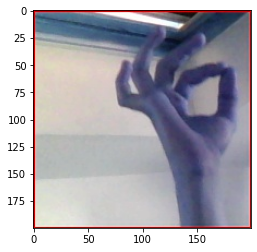


 (200, 200, 3)


In [ ]:
ex = cv2.imread('./asl_alphabet_train/asl_alphabet_train/F/F1009.jpg')
plt.imshow(ex)
plt.show()
print('\n',ex.shape)

## **Image processing**

**Change RGB images to gray scale**

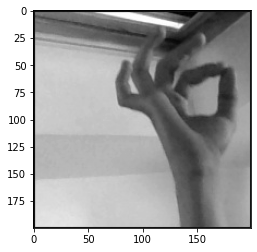

In [ ]:
from skimage import color

ex1 = cv2.cvtColor(ex, cv2.COLOR_BGR2GRAY)
plt.imshow(ex1,cmap = 'gray')

### **Denoising**

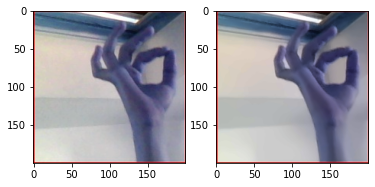

In [ ]:
def denoise(image):
    
    denoised_image = cv2.fastNlMeansDenoisingColored(image,None,h=2)
    
    return denoised_image

denoise_ex = denoise(ex)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(ex)
plt.subplot(1,2,2)
plt.imshow(denoise_ex)

**Visualization**

dataset includes images of 3d ndarray and the shape of (200, 200) with a color image as the size 3

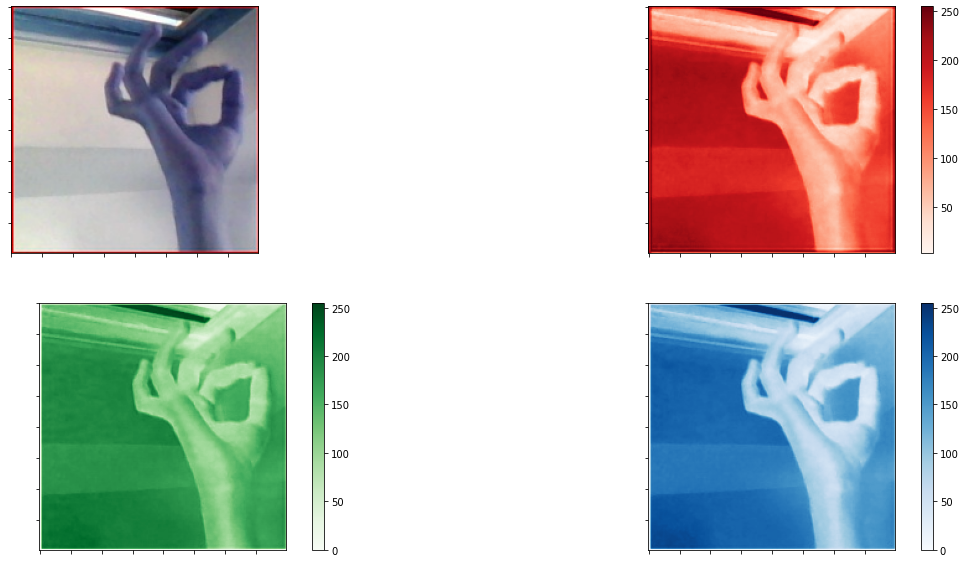

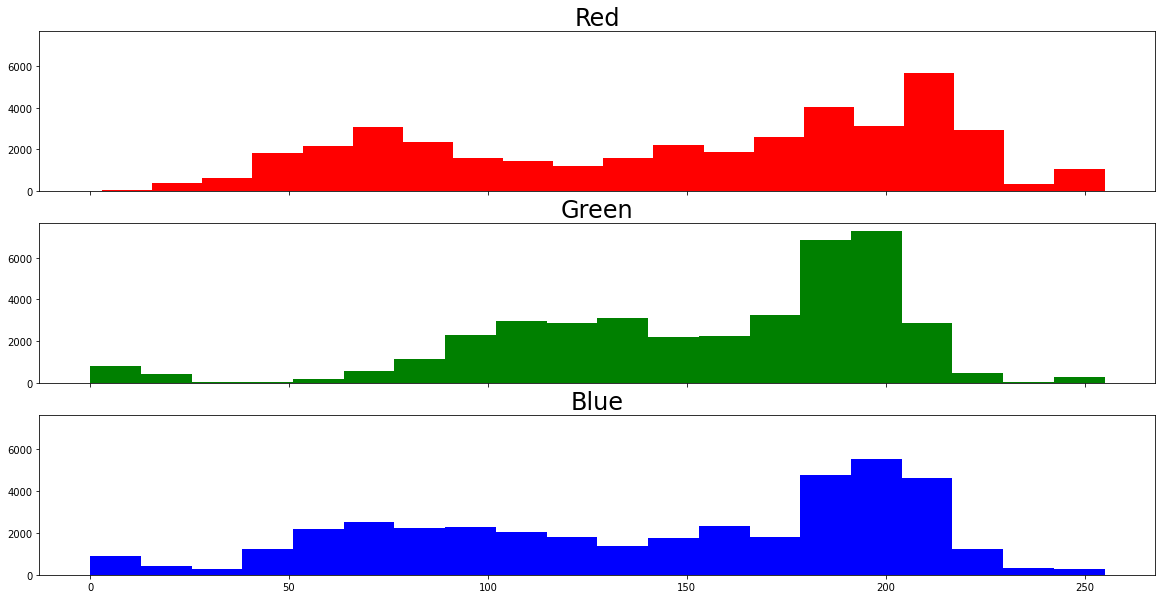

In [ ]:
# Color of the image
red = ex[:, :, 0]
blue= ex[:, :, 1]
green = ex[:,:,2]


#Set up the figure for plotting
fig, axs = plt.subplots(2,2, figsize=(20, 10))

cax_00 = axs[0,0].imshow(ex)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

#Plot histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(20, 10))

axs[0].hist(red.ravel(), bins=20, color = 'red')
axs[0].set_title('Red',fontsize=24)
axs[1].hist(green.ravel(), bins=20, color = 'green')
axs[1].set_title('Green',fontsize=24)
axs[2].hist(blue.ravel(), bins=20, color = 'blue')
axs[2].set_title('Blue',fontsize=24)

plt.show()


*   Preprocess images(resize,denoise,enhance contrast)
*   Defining a dictionary which contains labels and its mapping to a number which acts as class label.
*   loading image data and labels and then mapping those labels to the dictionary defined before.
*   Normalizing image data.
*   converting labels to one hot format as our keras model don't accept categorical label.
*   Normalizing image data.
*   creating training and test data by splitting original data into 95% of training data and 5% testing data.







In [11]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'del':27,'nothing':28}

def load_data():

    """
    Loads sign language dataset.
    """
    path = r"/content/drive/MyDrive/enel/archive_lessdata_new/archive_lessdata_new"
    images, labels = [], []
    for folder in os.listdir(path):
        
        print(folder, end = ' | ')
        #print(trainfile+"\\"+ folder)
        for image in os.listdir(path+"/"+ folder):
            temp_img = cv2.imread(path+"/"+folder+"/"+image)
            temp_img = cv2.fastNlMeansDenoisingColored(temp_img,None,h=2)
            temp_img = cv2.resize(temp_img, (128,128))
            images.append(temp_img)
            labels.append(labels_dict[folder])

    #convert images to numpy array and normalize        
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, random_state=42)
    
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = load_data()

y_train_ = keras.utils.np_utils.to_categorical(y_train,29)
y_test_ = keras.utils.np_utils.to_categorical(y_test,29)

S | R | W | U | X | space | Y | Z | V | T | K | P | nothing | N | M | O | J | I | L | Q | E | D | del | B | C | G | A | H | F | 
Loaded 5220 images for training, Train data shape = (5220, 128, 128, 3)
Loaded 580 images for testing Test data shape = (580, 128, 128, 3)


In [13]:
print("X_train shape  -> ", X_train.shape)
print("X_test shape   -> ", X_test.shape)
print("y_train_ shape -> ", y_train_.shape)
print("y_test_ shape  -> ", y_test_.shape)
print("len y_train    -> ", len(y_train))

X_train shape  ->  (5220, 128, 128, 3)
X_test shape   ->  (580, 128, 128, 3)
y_train_ shape ->  (5220, 29)
y_test_ shape  ->  (580, 29)
len y_train    ->  5220


### **Data Augmentation**

In [14]:
batch_size = 32
gen_params = {"featurewise_center":False, "samplewise_center":False, "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False, "zca_whitening":False, "rotation_range":15,\
              "width_shift_range":0, "height_shift_range":0, "shear_range":0, \
              "zoom_range":0, "fill_mode":'constant', "horizontal_flip":False, "vertical_flip":False
              }

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_test, seed = 1)

train_flow = train_gen.flow(X_train,y_train,batch_size = batch_size)
val_flow = val_gen.flow(X_test,y_test,batch_size = batch_size) 

-0.99629784 0.0021725427
-1.0 -0.9921876


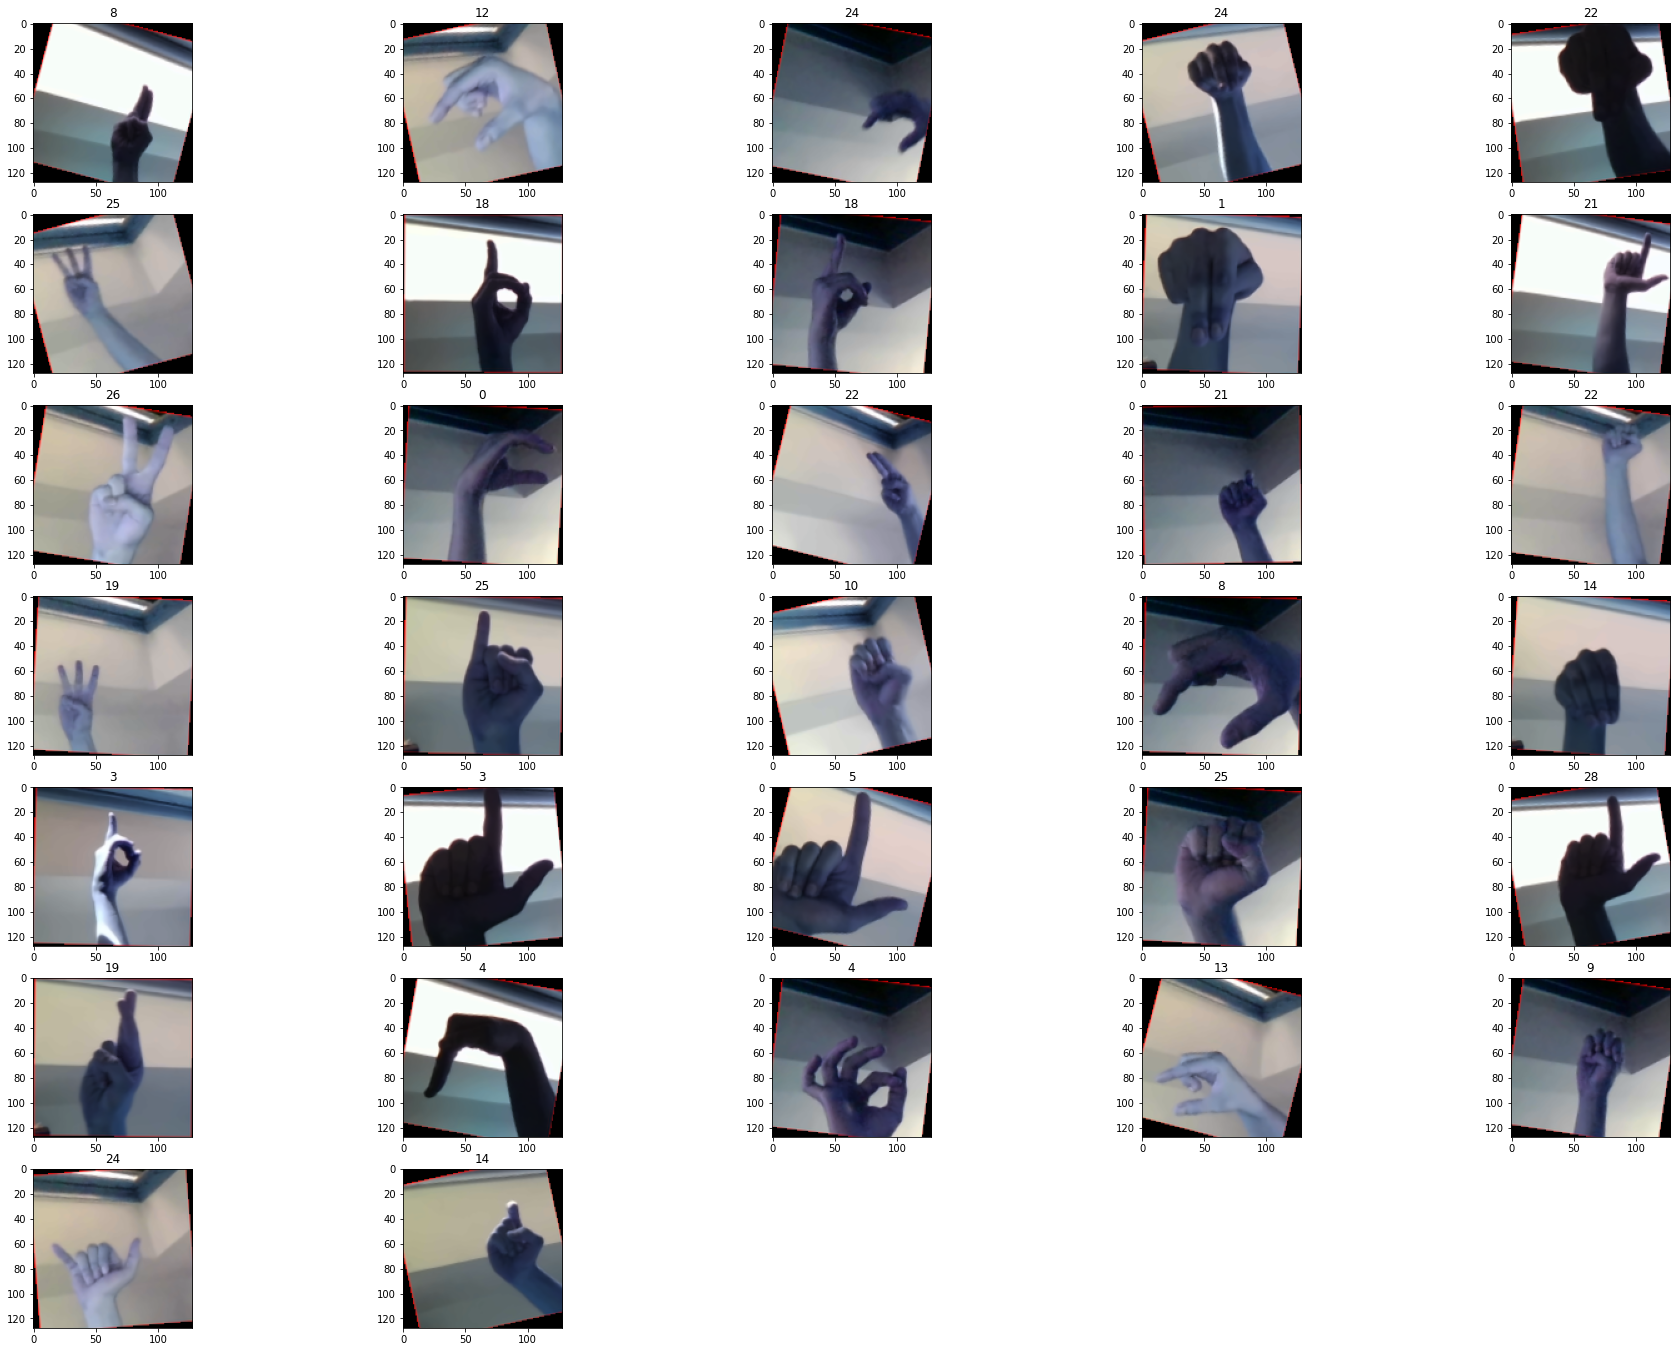

In [15]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title(y_train[ii])
plt.show()

### **Model Implementation MobileNet**

In [16]:
from tensorflow.keras.applications import MobileNet
base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet'  ,input_shape=(128, 128, 3))
x1 = tf.keras.layers.Flatten()( base_model.output )
x2 = tf.keras.layers.Dense(512, activation='sigmoid')( x1 )
outputs = tf.keras.layers.Dense(29, activation='softmax')( x2 )

model = tf.keras.models.Model( base_model.input , outputs )

17235968/17225924 [==============================] - 0s 0us/step


In [17]:
def fit_model(model,epochs):
    
    earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, # minimium amount of change to count as an improvement
    patience=23, # how many epochs to wait before stopping
    restore_best_weights = True)
    
    model_hist = model.fit(X_train, y_train_, batch_size = 50, epochs = epochs, validation_split = 0.1, callbacks =[earlystopping])
    
    return model_hist

### **Model Summary**

In [18]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

In [19]:
model.compile(optimizer = "adam", loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])


### **Model Fitting**

In [20]:
print('Train and Baseline Model with adam Optimizer and',50,' epochs') 
history = fit_model(model,50)

Train and Baseline Model with adam Optimizer and 50  epochs
Epoch 1/50
94/94 [==============================] - 22s 107ms/step - loss: 0.5329 - accuracy: 0.8772 - val_loss: 0.4434 - val_accuracy: 0.8678
Epoch 2/50
94/94 [==============================] - 9s 93ms/step - loss: 0.0775 - accuracy: 0.9823 - val_loss: 0.2733 - val_accuracy: 0.9368
Epoch 3/50
94/94 [==============================] - 9s 93ms/step - loss: 0.0301 - accuracy: 0.9932 - val_loss: 0.1177 - val_accuracy: 0.9732
Epoch 4/50
94/94 [==============================] - 9s 94ms/step - loss: 0.0250 - accuracy: 0.9945 - val_loss: 0.1865 - val_accuracy: 0.9330
Epoch 5/50
94/94 [==============================] - 9s 92ms/step - loss: 0.0447 - accuracy: 0.9891 - val_loss: 0.1423 - val_accuracy: 0.9598
Epoch 6/50
94/94 [==============================] - 9s 93ms/step - loss: 0.0332 - accuracy: 0.9913 - val_loss: 0.0436 - val_accuracy: 0.9885
Epoch 7/50
94/94 [==============================] - 9s 93ms/step - loss: 0.0180 - accuracy: 

### **Calculate model performance**

In [21]:
print('Training accuracy:', np.mean(history.history['accuracy']))
print('Training loss:', np.mean(history.history['loss']))
print('Validation accuracy:', np.mean(history.history['val_accuracy']))
print('Validation loss:', np.mean(history.history['val_loss']))

Training accuracy: 0.9924904191493988
Training loss: 0.03088669707532972
Validation accuracy: 0.955517234802246
Validation loss: 0.1622720381245017


### **Plot model performance metrics**

In [22]:
def plot_performance(hist_model):
    
    plt.plot(hist_model.history['accuracy'])
    plt.plot(hist_model.history['val_accuracy'])
    plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
    plt.title('accuracy plot - training vs validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()
    
    plt.plot(hist_model.history['loss'])
    plt.plot(hist_model.history['val_loss'])
    plt.legend(['training loss', 'validation loss'], loc = 'upper right')
    plt.title('loss plot - training vs validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

 Model with preprocesisng with adam Optimizer and 50  epochs


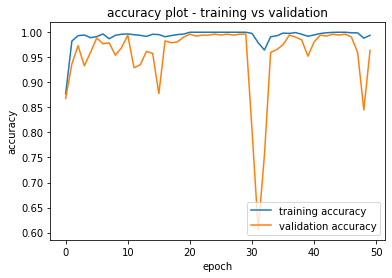

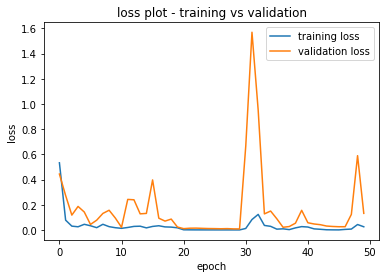

In [23]:
print(' Model with preprocesisng with adam Optimizer and',EPOCHS,' epochs') 
plot_performance(history)

### **Evaluate model on testing dataset**

In [24]:
def evaluate_model(model):
    test_loss,test_acc = model.evaluate(X_test, y_test_)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    
evaluate_model(model)

19/19 [==============================] - 1s 24ms/step - loss: 0.1482 - accuracy: 0.9569
Test accuracy: 0.9568965435028076
Test loss: 0.14818799495697021


In [25]:
from sklearn.metrics import classification_report

uniq_labels = sorted(os.listdir(trainfile))

y_pred = np.argmax(model.predict(X_test),1)
print(classification_report(y_test,y_pred))

print("Precision : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))
print("Recall    : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))
print("F1 Score  : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        20
           4       0.94      1.00      0.97        15
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        26
           8       1.00      0.88      0.93        16
           9       0.89      1.00      0.94        17
          10       0.84      1.00      0.91        16
          11       0.95      1.00      0.98        20
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        17
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        20
          17       0.82    

### **Confusion Matrix**

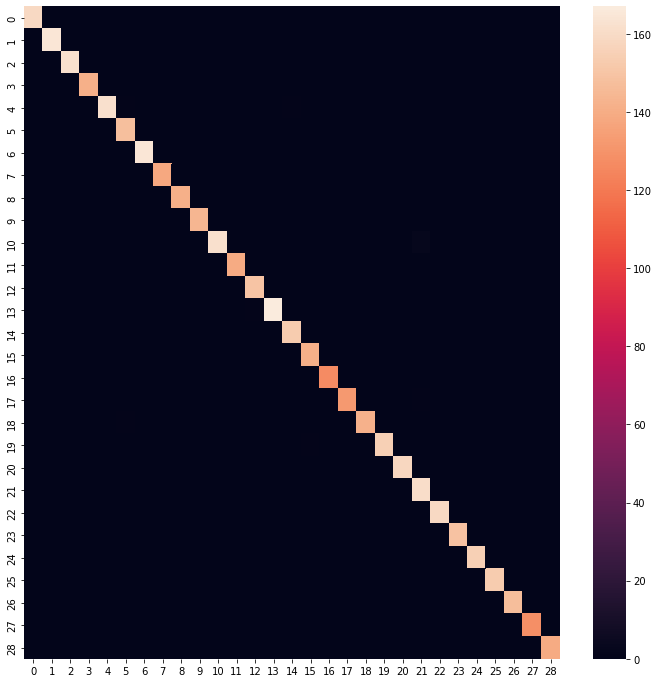

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_matrix(y_test, y_pred))
plt.show()


### **Model Saving**

In [26]:
# from keras.models import load_model
model.save('ASL_MobileNet.h5')
print("Model saved successfully...")


Model saved successfully...


### **GRAD-CAM Visualization**

In [ ]:
model = "/content/drive/MyDrive/ASL_MobileNet.h5"
model = keras.models.load_model(model)

In [27]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(128, 128))
    return heatmap_resized

In [28]:
from tensorflow import keras as K
last_conv_layer_name = list(filter(lambda x: isinstance(x, 
                                                        K.layers.Conv2D), 
                                   model.layers))[-1].name
print(last_conv_layer_name)

conv_pw_13


In [30]:
test_images = np.array(X_test)

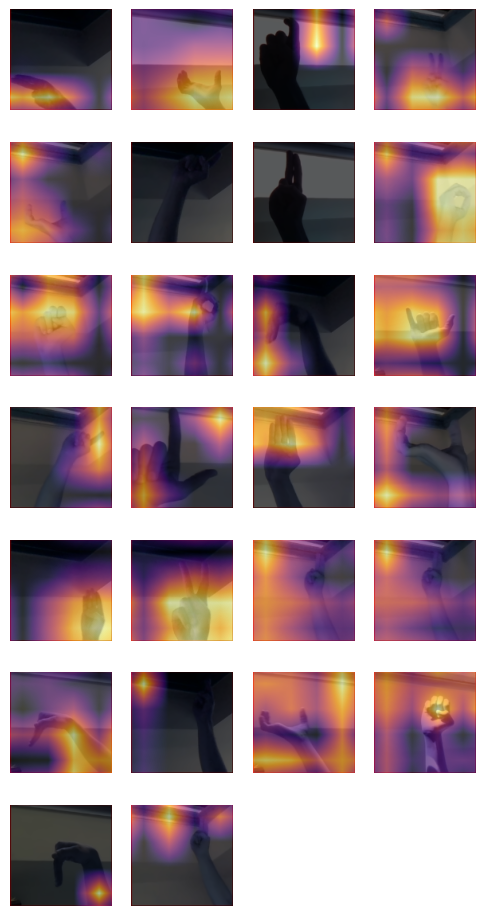

<Figure size 432x288 with 0 Axes>

In [41]:
# Remove last layer's 
model.layers[-1].activation = None

plt.figure(figsize = (6,12),dpi = 100)

for ii in range (26):
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(X_test[ii][np.newaxis,:,:], model, "conv_pw_13")
    plt.subplot(7,4,ii+1)
    plt.imshow(X_test[ii])
    plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
    #plt.colorbar()
    plt.axis("off")
plt.show()
plt.savefig('GRAD-CAM_MobileNet.jpg', dpi=300)

# Result visualizations and confusion matrix


In [35]:
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

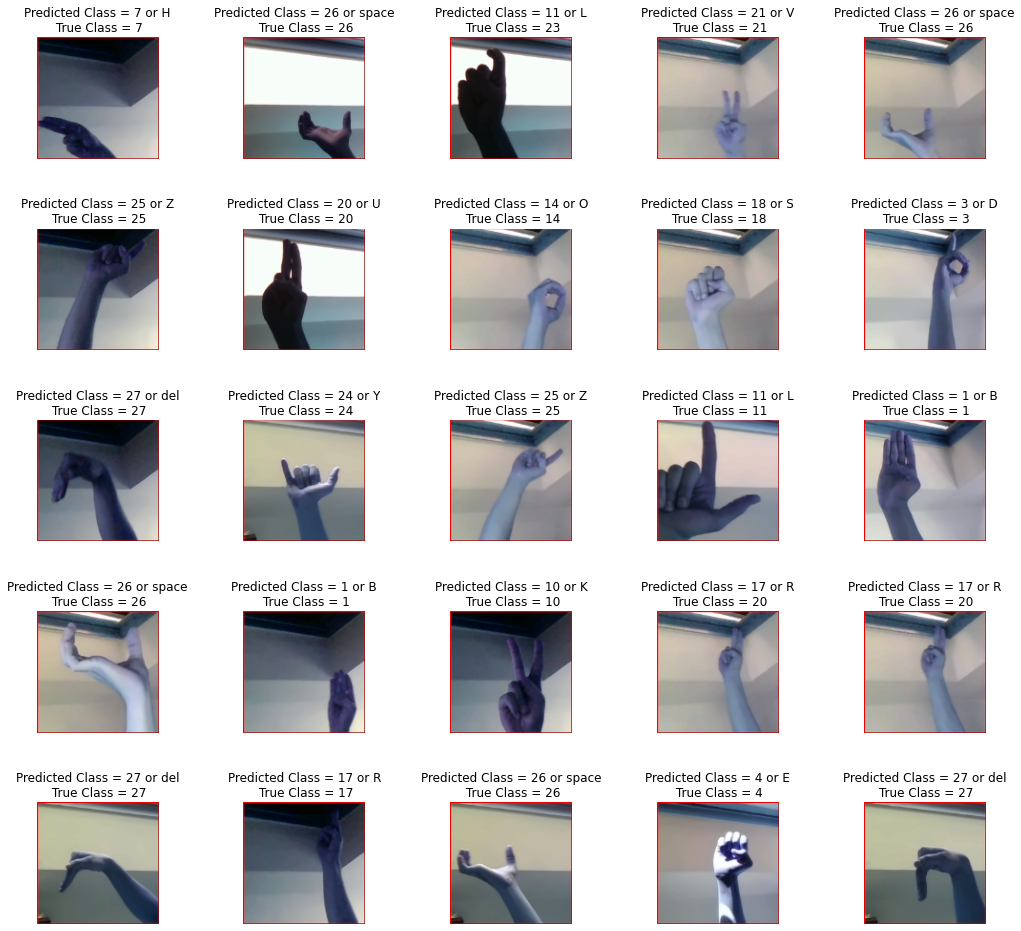

In [36]:
#Visualize predictions
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (17, 17))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Predicted Class = {predicted_classes[i]} or {dict((v,k) for k,v in labels_dict.items()).get(predicted_classes[i])}\n True Class = {y_test[i]}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.7)

plt.savefig('predictions_MobileNet.jpg', dpi=300)

Confusion matrix, without normalization


<Figure size 1440x1440 with 0 Axes>

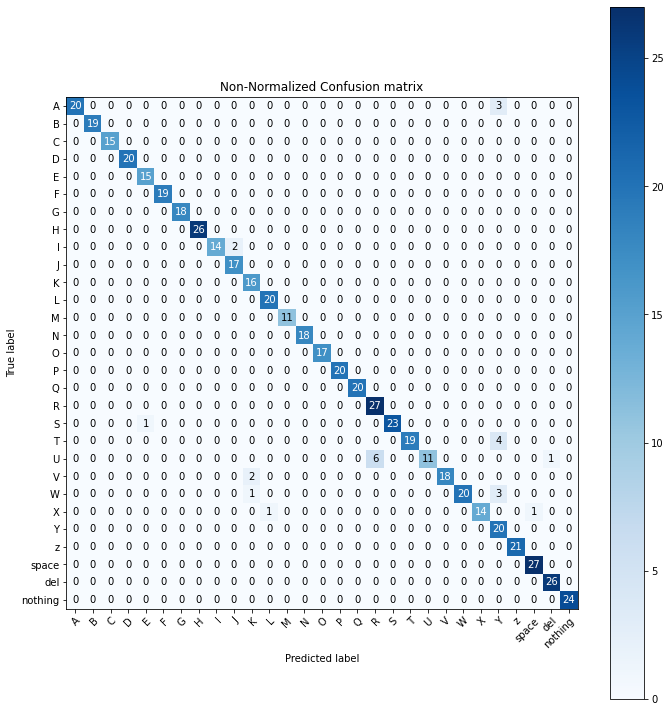

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predicted_classes)

#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(29),
           yticks=np.arange(29),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

#Specifying class labels
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'z', 'space', 'del', 'nothing']

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test, predicted_classes, classes = class_names, title='Non-Normalized Confusion matrix')
plt.savefig('confmatrix_MobileNet.jpg', dpi=300)
plt.show()
